In [187]:
"""
Train a classifier on top of a language model trained with `pretrain_lm.py`.
Optionally fine-tune LM before.
"""
import numpy as np
import pickle

import torch
import torch.nn.functional as F
from fastai.text import TextLMDataBunch, TextClasDataBunch, language_model_learner, text_classifier_learner, LanguageLearner
from fastai import fit_one_cycle
from fastai_contrib.utils import PAD, UNK, read_clas_data, PAD_TOKEN_ID, DATASETS, TRN, VAL, TST, ensure_paths_exists, get_sentencepiece
from fastai.text.transform import Vocab
from fastai.metrics import accuracy, accuracy_thresh, fbeta

import fire
from collections import Counter
from pathlib import Path

import pandas as pd
import csv
from functools import partial
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import mlflow
import glob
import shutil
import dask.dataframe as dd
import dask_ml as dm
from matplotlib import pyplot as plt
import itertools

In [169]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

# 青空文庫の著作切れ作品の作者を当てる

- 作品著作権フラグのない作品のうち11176件を形態素解析した結果が公開されている。新仮名データをダウンロードした。
- http://aozora-word.hahasoha.net/index.html
- この中から以下の著者のデータをダウンロードして、どの著者のデータか予測するモデルを作る(multi class)
    - akutagawa  
    - mori 
    - natsume 
    - sakaguchi 
    - yoshikawa 

## copy data

In [3]:
!ls ../aozora_classification/aozora_data/

akutagawa  log	mori  natsume  sakaguchi  yoshikawa


In [4]:
!head -50 ../aozora_classification/aozora_data/natsume/csv/bocchan.csv

"","auth","piece","line"
"0","natsume","bocchan.txt","坊っちゃん"
"1","natsume","bocchan.txt","夏目漱石"
"2","natsume","bocchan.txt",""
"3","natsume","bocchan.txt","-------------------------------------------------------"
"4","natsume","bocchan.txt","【テキスト中に現れる記号について】"
"5","natsume","bocchan.txt",""
"6","natsume","bocchan.txt","《》：ルビ"
"7","natsume","bocchan.txt","（例）坊っちゃん"
"8","natsume","bocchan.txt",""
"9","natsume","bocchan.txt","｜：ルビの付く文字列の始まりを特定する記号"
"10","natsume","bocchan.txt","（例）夕方｜折戸の"
"11","natsume","bocchan.txt",""
"12","natsume","bocchan.txt","：入力者注主に外字の説明や、傍点の位置の指定"
"13","natsume","bocchan.txt","（例）おくれんかな"
"14","natsume","bocchan.txt","-------------------------------------------------------"
"15","natsume","bocchan.txt",""
"16","natsume","bocchan.txt","一"
"17","natsume","bocchan.txt",""
"18","natsume","bocchan.txt","親譲りの無鉄砲で小供の時から損ばかりしている。"
"19","natsume","bocchan.txt","小学校に居る時分学校の二階から飛び降りて一週間ほど腰を抜かした事がある。"
"20","natsume","bocchan.txt","なぜそんな無闇をしたと聞く人があるかも知れぬ。"
"21","natsume","bocc

In [5]:
!mkdir -p data/Aozora/csv

In [6]:
csvs = glob.glob("../aozora_classification/aozora_data/*/csv/*.csv", recursive=True)

In [7]:
csvs

['../aozora_classification/aozora_data/mori/csv/bungeino_shugi.csv',
 "../aozora_classification/aozora_data/mori/csv/hon'yakuni_tsuite.csv",
 "../aozora_classification/aozora_data/mori/csv/sekaiman'yu.csv",
 '../aozora_classification/aozora_data/mori/csv/vater_sergius.csv',
 '../aozora_classification/aozora_data/mori/csv/gengono_kigen_fuki.csv',
 '../aozora_classification/aozora_data/mori/csv/fumizukai.csv',
 '../aozora_classification/aozora_data/mori/csv/ogai_gyoshitowa_darezo.csv',
 '../aozora_classification/aozora_data/mori/csv/konton.csv',
 '../aozora_classification/aozora_data/mori/csv/tsuina.csv',
 '../aozora_classification/aozora_data/mori/csv/izawa_ranken.csv',
 '../aozora_classification/aozora_data/mori/csv/faust.csv',
 '../aozora_classification/aozora_data/mori/csv/saigono_ikku.csv',
 '../aozora_classification/aozora_data/mori/csv/warai.csv',
 '../aozora_classification/aozora_data/mori/csv/saru.csv',
 '../aozora_classification/aozora_data/mori/csv/gyogenki.csv',
 '../aozora_c

In [8]:
for f in csvs:
    shutil.copy(f,'data/Aozora/csv/')

In [9]:
!ls data/Aozora/csv/

01amakusa_shiro.csv			kuriyama_daizen.csv
01ango_isejinguni_yuku.csv		kuroda_josui.csv
01ango_shinnihonfudoki_kadai.csv	kurotanimura.csv
01ashikaga_jo.csv			kusamakura.csv
01dokushaeno_kojo.csv			kuse.csv
01_hangan_chimatao_iku.csv		kyo.csv
01jo.csv				kyoikuto_bungei.csv
01jo_kenno_yonkunshi.csv		kyokazenshu_mokuroku.csv
01mayaku_jisatsu_shukyo.csv		kyokundan.csv
01shinden_gyoshinryu.csv		kyoni_tsukeru_yube.csv
02basara_jo.csv				kyoshikun.csv
02butokai_satsujinjiken.csv		kyosono_bungaku.csv
02chino_maki.csv			kyoto_nikki.csv
02choseiryu.csv				kyoyu.csv
02dokyo_doji.csv			london.csv
02dotonbori_makaritoru.csv		london_shosoku.csv
02_ooka_echizennokami.csv		los_caprichos.csv
02takachihoni_fuyuame_fureri.csv	maboroshino_tate.csv
02tenkoko_joshi.csv			machiwa_furusato.csv
02toenno_maki.csv			machiwa_furusato_sakusha.csv
02yagyu_sekishusai.csv			mado.csv
03datemasamuneno_shiro.csv		maihime.csv
03gunseino_maki.csv			majutsu.csv
03hanatenguryu.csv			makinosanno_saiten.csv
03hayashizaki_jins

## read data

In [38]:
ddf = dd.read_csv('data/Aozora/csv/*.csv')

In [39]:
ddf.head()

,Unnamed: 0,auth,piece,line
0,0,sakaguchi,01_hangan_chimatao_iku.txt,安吾人生案内
1,1,sakaguchi,01_hangan_chimatao_iku.txt,その一〔判官巷を往く〕
2,2,sakaguchi,01_hangan_chimatao_iku.txt,坂口安吾
3,3,sakaguchi,01_hangan_chimatao_iku.txt,NaN
4,4,sakaguchi,01_hangan_chimatao_iku.txt,----------------------------------------------...


In [40]:
ddf = ddf.rename(columns={'Unnamed: 0':'line_num'})

In [41]:
ddf.dtypes

line_num     int64
auth        object
piece       object
line        object
dtype: object

In [42]:
ddf['auth'].unique().compute()

0    sakaguchi
1    yoshikawa
2    akutagawa
3         mori
4      natsume
Name: auth, dtype: object

In [43]:
# filter lines
# line number >=20 and number of letters >= 20
ddf[(ddf['line_num']>=20) & (ddf['line'].str.len()>=20)].sample(frac=0.2).head()

,line_num,auth,piece,line
27,27,sakaguchi,01_hangan_chimatao_iku.txt,もっとも、一ツはラジオの社会の窓だそうだが、ラジオが探訪する以上は直前に新聞記事でもあったはずだ。
104,104,sakaguchi,01_hangan_chimatao_iku.txt,映画館を出るとピースを買ってのんだが、うまくなかった。
97,97,sakaguchi,01_hangan_chimatao_iku.txt,あの日の朝も、父とちょっとしたことから口論になり、母あてに遺書を書きました。
323,323,sakaguchi,01_hangan_chimatao_iku.txt,なぜならヤケまぎれに一方的に走りだす口実を得ても、実際にそれをキッカケにして踏み切る娘よりは...
426,426,sakaguchi,01_hangan_chimatao_iku.txt,この役人が役人でない時は鬼畜の性を発揮する人間ではないのであろうが、ひとたび役人となると、威...


In [44]:
ddf_fitered = ddf.loc[(ddf['line_num']>=20) & (ddf['line'].str.len()>=20),['auth','line']]

In [15]:
ddf_fitered['auth'].unique().compute()

0    sakaguchi
1    yoshikawa
2    akutagawa
3         mori
4      natsume
Name: auth, dtype: object

In [16]:
ddf_fitered.groupby('auth').count().compute()

,line
auth,
sakaguchi,96401
yoshikawa,224517
akutagawa,45793
mori,54211
natsume,68801


In [17]:
ddf_fitered.shape[0].compute()

489723

### train test split

In [45]:
df = ddf_fitered.compute()

In [46]:
df.head()

,auth,line
23,sakaguchi,仕事の用で旅にでることが多いので、その期間の新聞を読み損うことが少くない。
24,sakaguchi,旅から戻ってきて、たまった古新聞を一々見る気持にもならないので、いろいろの重大ニュースを知ら...
26,sakaguchi,そんな次第で、オール読物の編輯部からきた三ツの手記のうち、二ツの出来事はちょうど私が旅行中で...
27,sakaguchi,もっとも、一ツはラジオの社会の窓だそうだが、ラジオが探訪する以上は直前に新聞記事でもあったはずだ。
29,sakaguchi,はじめの相談では、月々の今日的な出来事、主として犯罪の犯人の手記にもとづく社会時評というので...


In [241]:
trn_val, tst = train_test_split(df,test_size=0.05,random_state=0)

In [242]:
trn, val = train_test_split(trn_val,test_size=5/95,random_state=0)

In [243]:
trn.head()

,auth,line
1588,yoshikawa,『いちど、もっとひどく、血を吐いたこともあるから』
5134,yoshikawa,――で、ここの大廊下を鈴の間の廊と呼びならわしているのであった。
5156,yoshikawa,旅先だと思ってたくさんおいじめ、高麗村へ帰ったらお祖父様にいいつけてあげるから」
479,akutagawa,今度掲げるだけに「大導寺信輔の半生」と言う題は相当しないのに違いないが、他に替る題もない為に...
6267,yoshikawa,底本：「私本太平記（五）」吉川英治歴史時代文庫、講談社


In [244]:
val.head()

,auth,line
300,akutagawa,しかし、私が閣下にこう云う事を御訴え致すのは、単に私たち夫妻に無理由な侮辱が加えられるからば...
2652,yoshikawa,「――強右衛門とやら、万死に一生もあるまじき中を、よくこれまで使いに参ってくれたな。
290,akutagawa,それからは、「ただあなたがお気の毒ね」と申して、じっと私の顔を見つめたきり、涙を乾かしてしま...
21,akutagawa,まるで濡れた壁土のような、重苦しい黄色である。
6354,yoshikawa,関羽は打ち消して、しきりと陽気な話題へわざと話をそらした。


In [245]:
tst.head()

,auth,line
50,akutagawa,あの皸だらけの頬は愈赤くなつて、時々｜鼻洟をすすりこむ音が、小さな息の切れる声と一しよに、せ...
89,sakaguchi,私は検事の訊問などにも、易者と同じような最大公約数的な設問法がとりいれられているムキがあるよ...
872,yoshikawa,――で、昨日から、六波羅兵と放免（密偵）どもの、煮炊きの跡や馬糞やらで、そこは狼藉を極めていた。
536,akutagawa,今日の本所は火事には会っても、洪水には会うことはないであろう。
448,akutagawa,ところが、その日は、小姓の手から神酒を入れた瓶子を二つ、三宝へのせたまま受取って、それを神前...


In [246]:
print('Data size')
print('Train: {}'.format(trn.shape[0]))
print('Validate: {}'.format(val.shape[0]))
print('Test: {}'.format(tst.shape[0]))

Data size
Train: 440749
Validate: 24487
Test: 24487


### save

In [247]:
trn.to_csv('data/Aozora/train.csv',header=None,index=None)

In [248]:
val.to_csv('data/Aozora/valid.csv',header=None,index=None)

In [249]:
tst.to_csv('data/Aozora/test.csv',header=None,index=None)

## prepare data for lm fine tuning and classification
basically copying from train_cls.py

In [250]:
data_dir='data'
lang='ja' 
cuda_id=0 
pretrain_name='wt-100' 
model_dir='data/wiki/ja-100/models'
fig_dir='data/wiki/ja-100/figs'
max_vocab=16000
name='Aozora-clas'
dataset='Aozora' 
frac_ds=1.0
spm_dir = 'data/wiki/ja/'

In [251]:
data_dir = Path(data_dir)
assert data_dir.name == 'data',\
    f'Error: Name of data directory should be data, not {data_dir.name}.'
dataset_dir = data_dir / dataset
model_dir = Path(model_dir)
fig_dir = Path(fig_dir)
fig_dir.mkdir(exist_ok=True)

In [252]:
if not torch.cuda.is_available():
    print('CUDA not available. Setting device=-1.')
    cuda_id = -1
torch.cuda.set_device(cuda_id)

print(f'Dataset: {dataset}. Language: {lang}.')

Dataset: Aozora. Language: ja.


In [253]:
# here we're just loading the trained spm model
sp = get_sentencepiece(spm_dir, None, 'wt-all', vocab_size=max_vocab)

In [254]:
# load train, valid in df
train_df = pd.read_csv(dataset_dir/'train.csv',header=None)
valid_df = pd.read_csv(dataset_dir/'valid.csv',header=None)
test_df = pd.read_csv(dataset_dir/'test.csv',header=None)

In [255]:
train_df.head()

,0,1
0,yoshikawa,『いちど、もっとひどく、血を吐いたこともあるから』
1,yoshikawa,――で、ここの大廊下を鈴の間の廊と呼びならわしているのであった。
2,yoshikawa,旅先だと思ってたくさんおいじめ、高麗村へ帰ったらお祖父様にいいつけてあげるから」
3,akutagawa,今度掲げるだけに「大導寺信輔の半生」と言う題は相当しないのに違いないが、他に替る題もない為に...
4,yoshikawa,底本：「私本太平記（五）」吉川英治歴史時代文庫、講談社


### lm data

In [256]:
data_lm = TextLMDataBunch.from_df(path=dataset_dir,train_df=train_df,valid_df=valid_df,test_df=test_df,**sp)

### classification data

In [257]:
data_clas = TextClasDataBunch.from_df(path=dataset_dir,train_df=train_df,valid_df=valid_df,test_df=test_df,**sp)

In [258]:
data_clas.valid_ds.y.c2i

{'akutagawa': 0, 'mori': 1, 'natsume': 2, 'sakaguchi': 3, 'yoshikawa': 4}

### save textdatabunch with multiple data sizes for train
- save time when testing models with different train data sizes

In [259]:
cache_name='tmp/lm/full'
caceh_name = Path(cache_name)

In [260]:
data_lm.save(cache_name)

In [261]:
data_lm.path

PosixPath('data/Aozora')

In [262]:
Path(data_dir/dataset)

PosixPath('data/Aozora')

In [263]:
data_lm_read = TextLMDataBunch.load(path=Path(data_dir/dataset),cache_name=cache_name)

In [264]:
data_lm

TextLMDataBunch;
Train: LabelList
y: LMLabel (440749 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/Aozora
x: LMTextList (440749 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁『 いち ど 、 もっと ひ ど く 、 血 を 吐 いた こともある から 』, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ ― ― で 、 ここ の大 廊 下 を 鈴 の間の 廊 と呼び なら わ している の であった 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 旅 先 だ と思って たくさん お いじめ 、 高麗 村 へ 帰った ら お 祖父 様に いい つけ て あげ る から 」, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 今 度 掲げ る だけ に 「 大 導 寺 信 輔 の 半 生 」 と言う 題 は 相当 しない の に 違い ない が 、 他に 替 る 題 もない 為に や む を得 ず 用いる ことにした 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 底 本 : 「 私 本 太平 記 ( 五 )」 吉川 英 治 歴史 時代 文庫 、 講談社]...
Path: data/Aozora;
Valid: LabelList
y: LMLabel (24487 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/Aozora
x: LMTextList (24487 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁しかし 、 私 が 閣 下に こう <unk> う 事を 御 訴え 致 す の は 、 単に 私たち 夫妻 に 無 理由 な <unk> が 加えられ る から ばかり では ご ざい ません 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁「 ― ― 強 右衛門 

In [265]:
data_lm_read

TextLMDataBunch;
Train: LabelList
y: LMLabel (440749 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/Aozora
x: LMTextList (440749 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁『 いち ど 、 もっと ひ ど く 、 血 を 吐 いた こともある から 』, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ ― ― で 、 ここ の大 廊 下 を 鈴 の間の 廊 と呼び なら わ している の であった 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 旅 先 だ と思って たくさん お いじめ 、 高麗 村 へ 帰った ら お 祖父 様に いい つけ て あげ る から 」, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 今 度 掲げ る だけ に 「 大 導 寺 信 輔 の 半 生 」 と言う 題 は 相当 しない の に 違い ない が 、 他に 替 る 題 もない 為に や む を得 ず 用いる ことにした 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 底 本 : 「 私 本 太平 記 ( 五 )」 吉川 英 治 歴史 時代 文庫 、 講談社]...
Path: data/Aozora;
Valid: LabelList
y: LMLabel (24487 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/Aozora
x: LMTextList (24487 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁しかし 、 私 が 閣 下に こう <unk> う 事を 御 訴え 致 す の は 、 単に 私たち 夫妻 に 無 理由 な <unk> が 加えられ る から ばかり では ご ざい ません 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁「 ― ― 強 右衛門 

successfully saved and loaded full length TextLMDataBunch

In [266]:
cache_name = Path('tmp/clas/full')
data_clas.save(cache_name)

In [267]:
data_clas_read = TextClasDataBunch.load(path=Path(data_dir/dataset),cache_name=cache_name)

In [268]:
data_clas_read

TextClasDataBunch;
Train: LabelList
y: CategoryList (440749 items)
[Category yoshikawa, Category yoshikawa, Category yoshikawa, Category akutagawa, Category yoshikawa]...
Path: .
x: TextList (440749 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁『 いち ど 、 もっと ひ ど く 、 血 を 吐 いた こともある から 』, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ ― ― で 、 ここ の大 廊 下 を 鈴 の間の 廊 と呼び なら わ している の であった 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 旅 先 だ と思って たくさん お いじめ 、 高麗 村 へ 帰った ら お 祖父 様に いい つけ て あげ る から 」, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 今 度 掲げ る だけ に 「 大 導 寺 信 輔 の 半 生 」 と言う 題 は 相当 しない の に 違い ない が 、 他に 替 る 題 もない 為に や む を得 ず 用いる ことにした 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 底 本 : 「 私 本 太平 記 ( 五 )」 吉川 英 治 歴史 時代 文庫 、 講談社]...
Path: data/Aozora;
Valid: LabelList
y: CategoryList (24487 items)
[Category akutagawa, Category yoshikawa, Category akutagawa, Category akutagawa, Category yoshikawa]...
Path: .
x: TextList (24487 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁しかし 、 私 が 閣 下に こう <unk> う 事を 御 訴え 致 す の は 、 単に 私たち 夫妻 に 無 理由 な <unk> が 加えられ る

In [269]:
# full train data has about 400k items so these numbers of train data will be saved for experiments
num_trains = [1e2,1e3,1e4,1e5]

In [270]:
for num_train in num_trains:
    num_train = int(num_train)
    print(num_train)
    
    # sample train data
    tmp_train_df = train_df.sample(n=num_train,random_state=42)
    
    # create data bunches
    tmp_lm = TextLMDataBunch.from_df(path=dataset_dir,train_df=tmp_train_df,valid_df=valid_df,test_df=test_df,**sp)
    tmp_clas = TextClasDataBunch.from_df(path=dataset_dir,train_df=tmp_train_df,valid_df=valid_df,test_df=test_df,**sp)
    
    # name of tmp cache
    tmp_cache_lm = Path(f'tmp/lm/{num_train}')
    tmp_cache_clas = Path(f'tmp/clas/{num_train}')
    
    # save
    tmp_lm.save(tmp_cache_lm)
    tmp_clas.save(tmp_cache_clas)

# LM fine tuning & Classification

In [271]:
def lm_fine_tuning( data_lm, lm_lr, bptt, emb_sz, nh, nl, qrnn,
                pad_token,
                pretrained_fnames, 
                model_dir,
                lm_enc_finetuned,
                lm_drop_mult, use_pretrained_lm,fine_tune_lm):
    
    
    if not use_pretrained_lm:
        pretrained_fnames = None
    
    learn = language_model_learner(
        data_lm, bptt=bptt, emb_sz=emb_sz, nh=nh, nl=nl, qrnn=qrnn,
        pad_token=pad_token,
        pretrained_fnames=pretrained_fnames, 
        path=model_dir.parent, model_dir=model_dir.name,
        drop_mult=lm_drop_mult
    )
    
    if fine_tune_lm:
        print('Fine-tuning the language model...')
        learn.unfreeze()
        learn.fit(4, slice(lm_lr/(10**2), lm_lr))
    #     learn.fit(10, slice(1e-3, 1e-1))
    else:
        print('Skipping fine tuning')

    # save fine tuned lm
    print(f"Saving models at {learn.path / learn.model_dir}")
    learn.save_encoder(lm_enc_finetuned)
    
    return learn

In [272]:
def classify_multiclas(data_clas, clas_lr, bptt, 
                        pad_token,
                        model_dir,
                        qrnn, emb_sz, nh, nl,clas_drop_mult,
                        fine_tune_lm, use_lm,cls_weights):
    
    
    print("Starting classifier training")
    learn = text_classifier_learner(data_clas, bptt=bptt, pad_token=pad_token,
                                  path=model_dir.parent, model_dir=model_dir.name,
                                  qrnn=qrnn, emb_sz=emb_sz, nh=nh, nl=nl,drop_mult=clas_drop_mult
                                    )
    learn.model.reset()
    
    if use_lm:
        print('Loading language model')
        lm_enc = lm_enc_finetuned # if fine_tune_lm else lm_name
        learn.load_encoder(lm_enc)
    else:
        print('Training from scratch without language model')

    # train
    learn.freeze_to(-1)
    learn.fit_one_cycle(1, clas_lr, moms=(0.8, 0.7), wd=1e-7)

    learn.freeze_to(-2)
    learn.fit_one_cycle(1, slice(clas_lr / (2.6 ** 4), clas_lr), moms=(0.8, 0.7), wd=1e-7)

    learn.freeze_to(-3)
    learn.fit_one_cycle(1, slice(clas_lr / (2.6 ** 4), clas_lr), moms=(0.8, 0.7), wd=1e-7)

    learn.unfreeze()
    learn.fit_one_cycle(2, slice(clas_lr / (2.6 ** 4), clas_lr), moms=(0.8, 0.7), wd=1e-7)
    
    # results
    results={}
    results['accuracy_multi'] = learn.validate()[1]
    results['F1'] = learn.validate()[2]
    print(results)
    
    # save classifier
    print(f"Saving models at {learn.path / learn.model_dir}")
    learn.save(f'{model_name}_{name}')
    
    # prediction on validation data
    preds=learn.get_preds()

    # prediction
    p=preds[0]
    p = p.tolist()
    p = np.asarray(p)

    # binarize
    y_pred = (p>=0.5)*1.0


    # target
    t = preds[1].tolist()
    y_true = np.asarray(t)
    
    return y_true, y_pred

In [273]:
def evaluation(y_true,y_pred):
    ## metrics
    f1_micro = f1_score(y_true,y_pred,average='micro')
    f1_macro = f1_score(y_true,y_pred,average='macro')

    print('F1 score')
    print('micro: {}'.format(f1_micro))
    print('macro: {}'.format(f1_macro))

    precision_micro = precision_score(y_true,y_pred,average='micro')
    precision_macro = precision_score(y_true,y_pred,average='macro')

    print('\nPrecision score')
    print('micro: {}'.format(precision_micro))
    print('macro: {}'.format(precision_macro))

    recall_micro = recall_score(y_true,y_pred,average='micro')
    recall_macro = recall_score(y_true,y_pred,average='macro')

    print('\nRecall score')
    print('micro: {}'.format(recall_micro))
    print('macro: {}'.format(recall_macro))
    
    acc = accuracy_score(y_true,y_pred,average='macro')

    print('\nAccuracy score: {}'.format(acc))
    
    results = dict(
        f1_micro=f1_micro,
        f1_macro=f1_macro,
        precision_micro=precision_micro,
        precision_macro=precision_macro,
        recall_micro=recall_micro,
        recall_macro=recall_macro,
        accuracy=acc
    )
    
    return results

###  Parameters

In [274]:
# common to lm fine tuning and classification
qrnn=True
bs=20 
bptt=70
pad_token=PAD_TOKEN_ID

if qrnn:
    emb_sz, nh, nl = 400, 1550, 3
else:
    emb_sz, nh, nl = 400, 1150, 3
    
# lm fine tuning
fine_tune_lm=True 
lm_lr=2e-2
lm_drop_mult=0.5
use_pretrained_lm=True

# classification
clas_lr=2e-2
clas_drop_mult=0.1
use_lm=True

# reduction of training data
frac_ds = 1.0

### look for appropriate lrs

In [275]:
# train num_train items
num_train = 10000
data_lm = TextLMDataBunch.load(path=Path(data_dir/dataset),cache_name=Path(f'tmp/lm/{num_train}'))
data_clas = TextClasDataBunch.load(path=Path(data_dir/dataset),cache_name=Path(f'tmp/clas/{num_train}'))

In [276]:
# lm
model_name = 'qrnn' if qrnn else 'lstm'
lm_name = f'{model_name}_{pretrain_name}'
pretrained_fnames = (lm_name, f'itos_{pretrain_name}')

ensure_paths_exists(data_dir,
                    dataset_dir,
                    model_dir,
                    model_dir/f"{pretrained_fnames[0]}.pth",
                    model_dir/f"{pretrained_fnames[1]}.pkl")
lm_enc_finetuned  = f"{lm_name}_{dataset}_enc"
learn = language_model_learner(
    data_lm, bptt=bptt, emb_sz=emb_sz, nh=nh, nl=nl, qrnn=qrnn,
    pad_token=pad_token,
    pretrained_fnames=pretrained_fnames, 
    path=model_dir.parent, model_dir=model_dir.name,
    drop_mult=lm_drop_mult
)

learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


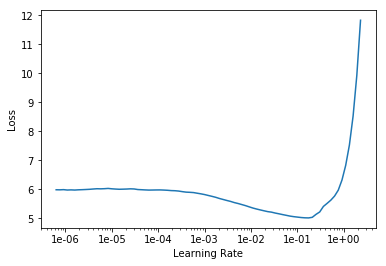

In [277]:
learn.lr_find()
learn.recorder.plot() 

In [278]:
lm_lr = 1e-2
learn.fit(4, slice(lm_lr/(10**2), lm_lr))

Total time: 00:42
epoch  train_loss  valid_loss  accuracy
1      3.942037    3.458684    0.454033  (00:10)
2      3.659939    3.391264    0.459637  (00:10)
3      3.508347    3.362652    0.462085  (00:10)
4      3.410895    3.343238    0.464787  (00:10)



In [279]:
learn.save_encoder(lm_enc_finetuned)

In [280]:
learn.predict('料金が高い',n_words=200,no_unk=False)

Total time: 00:11



'料金が高い 戦 転 <unk> 行 が よく な 四 根 を く 大 es us and ( つく ようになる が 、 京都 d 家の 何 たる 時代 クロ を <unk> vo f l d 軍 見 絶 足 を 教え る 日 を追う て <unk> ) しい と <unk> のうち 、 神田 など もない 事が 真似 として 、 グ ・ グラ ア 、 彼ら と 、 古 屋 ン 1000 嫌い の バ と 、 別の ( 現 ぼう 栽培 は 公 二人 個々の 火 ここから 徳 を見 下 馬 車 が 想定 <unk> も 胸 、 お は 、 新人 の 現 、 誰 の 世話 も 、 朝日 の 付け て 等を 多数の 鳥羽 西 の 恩 は まもなく 、 美 と 時期に 過ぎ 、 ニス に ウン と 噂 降 ぎ る 野 の 和 姓 仙 、 不 当 会 が 、 富 さん には ず けい の 式 、 という意味 ( 待ち を受け 取った 機会 を得た が い な 14 種 が 、 やはり 、 <unk> の 別の で 考え 対抗 として 、 しかも 近く ひとり も 、 なお を一 <unk> の前に るべき 年 の は 思 惑 の 十 日 は <unk> 詰 ながら 、'

In [281]:
# change metric from accuracy to accuarcy_thresh and f1
accuracy_multi =  partial(accuracy_thresh,thresh=0.5,sigmoid=True)
f1 = partial(fbeta,thresh=0.5,beta=1,sigmoid=True) # corresponds to f1 score in sklearn with 'samples' option?

print("Starting classifier training")
learn = text_classifier_learner(data_clas, bptt=bptt, pad_token=pad_token,
                              path=model_dir.parent, model_dir=model_dir.name,
                              qrnn=qrnn, emb_sz=emb_sz, nh=nh, nl=nl,drop_mult=clas_drop_mult
                                )
learn.model.reset()

if use_lm:
    print('Loading language model')
    lm_enc = lm_enc_finetuned # if fine_tune_lm else lm_name
    learn.load_encoder(lm_enc)
else:
    print('Training from scratch without language model')

# change metric
# learn.metrics = [accuracy_multi,f1]

# CRITICAL STEP
#- need to adjust pos_weight of loss function to get the model working
# if cls_weights is not None:
#     pos_weight = torch.cuda.FloatTensor(cls_weights[data_clas.train_ds.y.classes].values)
#     bce_logits_weighted = partial(F.binary_cross_entropy_with_logits,  pos_weight=pos_weight)
#     learn.loss_func = bce_logits_weighted

# train
learn.freeze_to(-1)

Starting classifier training
Loading language model


In [282]:
learn.loss_func

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


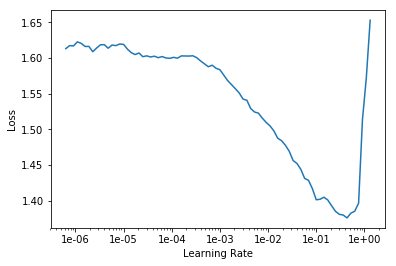

In [283]:
learn.lr_find()
learn.recorder.plot() 

In [284]:
clas_lr = 1e-2
learn.fit_one_cycle(1, slice(clas_lr / (2.6 ** 4), clas_lr), moms=(0.8, 0.7), wd=1e-7)

Total time: 00:11
epoch  train_loss  valid_loss  accuracy
1      0.998207    1.037132    0.620411  (00:11)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


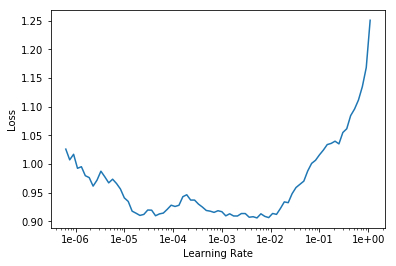

In [285]:
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot() 

In [286]:
clas_lr = 1e-2
learn.fit_one_cycle(1, slice(clas_lr / (2.6 ** 4), clas_lr), moms=(0.8, 0.7), wd=1e-7)

Total time: 00:11
epoch  train_loss  valid_loss  accuracy
1      0.913903    0.942221    0.655450  (00:11)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


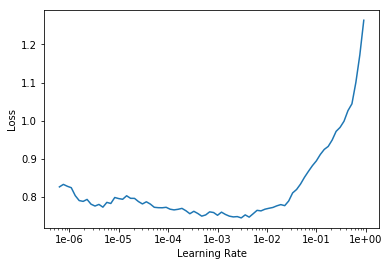

In [287]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot() 

In [288]:
clas_lr = 1e-6
learn.fit_one_cycle(1, slice(clas_lr / (2.6 ** 4), clas_lr), moms=(0.8, 0.7), wd=1e-7)

Total time: 00:13
epoch  train_loss  valid_loss  accuracy
1      0.822188    0.977703    0.643198  (00:13)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


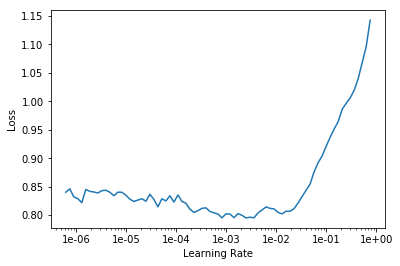

In [289]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot() 

In [290]:
# prediction on validation data
preds=learn.get_preds()

# prediction
p=preds[0]
p = p.tolist()
p = np.asarray(p)

# binarize
y_pred = p.argmax(axis=1)


# target
t = preds[1].tolist()
y_true = np.asarray(t)

In [291]:
p[:5]

array([[0.09, 0.1 , 0.1 , 0.45, 0.25],
       [0.21, 0.06, 0.03, 0.37, 0.34],
       [0.28, 0.18, 0.09, 0.15, 0.29],
       [0.24, 0.11, 0.04, 0.46, 0.16],
       [0.28, 0.17, 0.05, 0.15, 0.35]])

In [292]:
y_pred[:5]

array([3, 3, 4, 3, 4])

In [293]:
y_true[:5]

array([2, 2, 2, 3, 0])

In [294]:
data_clas.train_ds.y.classes

array(['akutagawa', 'mori', 'natsume', 'sakaguchi', 'yoshikawa'], dtype='<U9')

(array([ 2187.,     0.,  1729.,     0.,     0.,   612.,     0.,  5144.,     0., 14815.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

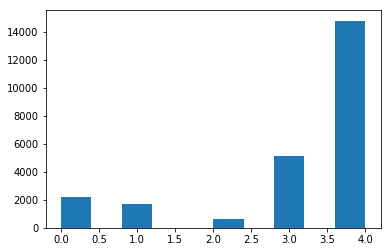

In [295]:
plt.hist(y_pred)

(array([ 2278.,     0.,  2646.,     0.,     0.,  3455.,     0.,  4816.,     0., 11292.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

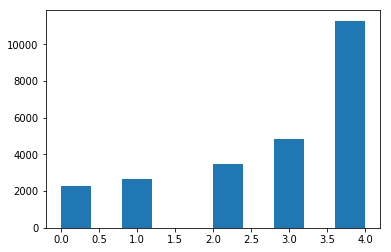

In [296]:
plt.hist(y_true)

(array([ 937.,    0., 1104.,    0.,    0., 1432.,    0., 1911.,    0., 4616.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

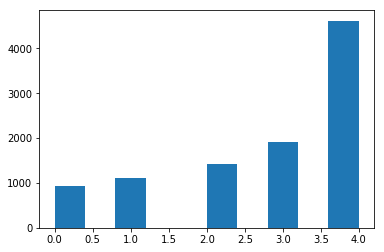

In [297]:
plt.hist(data_clas.train_ds.y.items.astype(int))

In [298]:
y_true.shape

(24487,)

In [299]:
accuracy_score(y_true,y_pred)

0.6431984318209663

In [300]:
confusion_matrix(y_true,y_pred)

array([[  720,   161,    38,   382,   977],
       [  318,  1124,    62,   423,   719],
       [  615,   185,   453,   790,  1412],
       [  336,   125,    31,  3035,  1289],
       [  198,   134,    28,   514, 10418]])

In [301]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [316]:
class_names = data_clas.valid_ds.y.classes
class_names

array(['akutagawa', 'mori', 'natsume', 'sakaguchi', 'yoshikawa'], dtype='<U9')

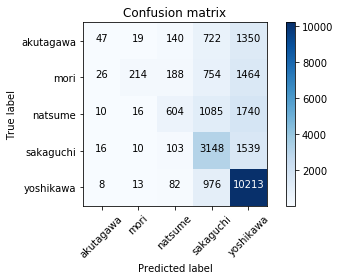

In [317]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

- 夏目漱石と予測して間違えることが多い。文体が平均的なのか、それとも他のみんなに影響を与えているからか
- 坂口安吾の文章は他の著者と間違えられることが多い。文体が揺れている？

In [304]:
train_df[train_df[0]=='sakaguchi'].head(20)

,0,1
7,sakaguchi,否、家出後の暫時の目鼻がほぼリンカクをなしていたのである。
15,sakaguchi,つまり荒君は非常に現実家のようだが、根柢的には夢想児なので、平野君とて、やっぱりそうだ。
22,sakaguchi,一般に犬は飼主を信頼するが人間を信頼していない。
24,sakaguchi,モチ竿の先端を見ている犬の目は、恐怖と、アワレミを乞う断末魔の目である。
26,sakaguchi,だから、昨晩のような不景気なときなら、第一、下の夫婦がグズグズしてやしない。
27,sakaguchi,「うちのチンピラは先生の愛読者なんですのよ。
28,sakaguchi,「オレはとにかく、今夜からは、サクラ拳闘クラブへ居候の合宿だ。
39,sakaguchi,誰しも人にお説教する程度の物の理は弁えていても、自分自身が理の如くに行為できるわけではない。
41,sakaguchi,まもなく二人の見知らぬ訪客が現れたのだ。
44,sakaguchi,ボクは強盗して生きのびるほどの度胸はないから、死ぬよりほかに仕方がない。


In [305]:
train_df[train_df[0]=='natsume'].head(20)

,0,1
17,natsume,ことに病気になって仰向に寝てからは、絶えず美くしい雲と空が胸に描かれた。
21,natsume,けれどもそれは強がちに、自分達の身の上について、特に御米の注意を惹くために口にした、故意の観...
25,natsume,私がここでとくに「近頃」と断ったのは、書生時代の古い回想から来たものであります。
32,natsume,小林は押問答の末、とうとう三枚のうち一枚を原の手に渡した。
38,natsume,向うの方で凸凹の地面をならして新墓地を作っている男が、鍬の手を休めて私たちを見ていた。
40,natsume,茶碗を下へ置かないで、そのまま口へつけた。
42,natsume,「堀田には出せ、私には出さないで好いと云う法がありますか」
47,natsume,……」ここにウィリアムとあるはわが四世の祖だとウィリアムが独り言う。
52,natsume,武者絵、錦絵、二枚つづき三枚つづきの絵も彼のいうがままに買ってくれた。
56,natsume,「なるほど梅に鶯だ」と自分も云いたくなった。


In [306]:
train_df[train_df[0]=='akutagawa'].head(20)

,0,1
3,akutagawa,今度掲げるだけに「大導寺信輔の半生」と言う題は相当しないのに違いないが、他に替る題もない為に...
9,akutagawa,水はただ突当りの橋の下へまっ直に一すじつづいている。
10,akutagawa,現にビルコフの伝記によれば、あの逞しいトルストイさへ半狂乱になつて家出したのは、つい近頃の新...
11,akutagawa,更に又諸家の文芸評論の中にもタイチ派とフランス派とのあるのを感じてゐる。
29,akutagawa,ではなぜその話を信じないのか？幽霊などを見る者は迷信に囚われて居るからである。
66,akutagawa,彼は特に、和泉屋のこの感服を好まないのである。
72,akutagawa,お蓮もまたどうかすると、弥勒寺橋の方へ引っ返そうとする。
79,akutagawa,僕も亦僕の一家に天才のないことに安んじてゐる。
82,akutagawa,殊に僕の親友だつた、嘴の腐つた学生のラツプは、――或けふのやうに曇つた午後です。
109,akutagawa,「実は手遅れになった病人だしするから、せめて火葬にする時だけは一等にしたいと思うんですがね。


## Assessments

### functions

In [386]:
def set_deterministic(deterministic=True):
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(0)
        np.random.seed(0)

In [387]:
def lm_fine_tuning( data_lm, lm_lr, bptt, emb_sz, nh, nl, qrnn,
                pad_token,
                pretrained_fnames, 
                model_dir,
                lm_enc_finetuned,
                lm_drop_mult, use_pretrained_lm,fine_tune_lm,deterministic):
    
    
    if not use_pretrained_lm:
        pretrained_fnames = None
    
    learn = language_model_learner(
        data_lm, bptt=bptt, emb_sz=emb_sz, nh=nh, nl=nl, qrnn=qrnn,
        pad_token=pad_token,
        pretrained_fnames=pretrained_fnames, 
        path=model_dir.parent, model_dir=model_dir.name,
        drop_mult=lm_drop_mult
    )
    
    set_deterministic(deterministic)
    
    if fine_tune_lm:
        print('Fine-tuning the language model...')
        learn.unfreeze()
        learn.fit(4, slice(lm_lr/(10**2), lm_lr))
    #     learn.fit(10, slice(1e-3, 1e-1))
    else:
        print('Skipping fine tuning')

    # save fine tuned lm
    print(f"Saving models at {learn.path / learn.model_dir}")
    learn.save_encoder(lm_enc_finetuned)
    
    return learn

In [388]:
def classify_multiclas(data_clas, clas_lr, bptt, 
                        pad_token,
                        model_dir,
                        qrnn, emb_sz, nh, nl,clas_drop_mult,
                        fine_tune_lm, use_lm,deterministic):
    
    
    print("Starting classifier training")
    learn = text_classifier_learner(data_clas, bptt=bptt, pad_token=pad_token,
                                  path=model_dir.parent, model_dir=model_dir.name,
                                  qrnn=qrnn, emb_sz=emb_sz, nh=nh, nl=nl,drop_mult=clas_drop_mult
                                    )
    learn.model.reset()
    
    if use_lm:
        print('Loading language model')
        lm_enc = lm_enc_finetuned # if fine_tune_lm else lm_name
        learn.load_encoder(lm_enc)
    else:
        print('Training from scratch without language model')

    # train
    set_deterministic(deterministic)
    
    learn.freeze_to(-1)
    learn.fit_one_cycle(1, clas_lr, moms=(0.8, 0.7), wd=1e-7)

    learn.freeze_to(-2)
    learn.fit_one_cycle(1, slice(clas_lr / (2.6 ** 4), clas_lr), moms=(0.8, 0.7), wd=1e-7)

    learn.freeze_to(-3)
    learn.fit_one_cycle(1, slice(clas_lr / (2.6 ** 4), clas_lr), moms=(0.8, 0.7), wd=1e-7)

    learn.unfreeze()
    learn.fit_one_cycle(2, slice(clas_lr / (2.6 ** 4), clas_lr), moms=(0.8, 0.7), wd=1e-7)
    
    # results
    results={}
    results['accuracy'] = learn.validate()[1]
    print(results)
    
    # save classifier
    print(f"Saving models at {learn.path / learn.model_dir}")
    learn.save(f'{model_name}_{name}')
    
    # prediction on validation data
    preds=learn.get_preds()

    # prediction
    p=preds[0]
    p = p.tolist()
    p = np.asarray(p)

    # binarize
    y_pred = p.argmax(axis=1)


    # target
    t = preds[1].tolist()
    y_true = np.asarray(t)
    
    return y_true, y_pred

In [309]:
def evaluation(y_true,y_pred):
    ## metrics
    f1_micro = f1_score(y_true,y_pred,average='micro')
    f1_macro = f1_score(y_true,y_pred,average='macro')

    print('F1 score')
    print('micro: {}'.format(f1_micro))
    print('macro: {}'.format(f1_macro))

    precision_micro = precision_score(y_true,y_pred,average='micro')
    precision_macro = precision_score(y_true,y_pred,average='macro')

    print('\nPrecision score')
    print('micro: {}'.format(precision_micro))
    print('macro: {}'.format(precision_macro))

    recall_micro = recall_score(y_true,y_pred,average='micro')
    recall_macro = recall_score(y_true,y_pred,average='macro')

    print('\nRecall score')
    print('micro: {}'.format(recall_micro))
    print('macro: {}'.format(recall_macro))
    
    acc = accuracy_score(y_true,y_pred)

    print('\nAccuracy score: {}'.format(acc))
    
    results = dict(
        f1_micro=f1_micro,
        f1_macro=f1_macro,
        precision_micro=precision_micro,
        precision_macro=precision_macro,
        recall_micro=recall_micro,
        recall_macro=recall_macro,
        accuracy=acc
    )
    
    return results

In [310]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [311]:
def save_confusion_matrix(y_true,y_pred,class_names,fn):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix')
    plt.gcf().savefig(fn)

In [365]:
# Create Params dictionary
class Params(object):
    def __init__(self, qrnn,bs,bptt,emb_sz, nh, nl,fine_tune_lm,lm_lr,lm_drop_mult,
                 use_pretrained_lm,clas_lr,clas_drop_mult,use_lm,num_train,deterministic):
        self.qrnn = qrnn
        self.fine_tune_lm = fine_tune_lm
        self.bs = bs
        self.bptt = bptt
        self.emb_sz = emb_sz
        self.nh = nh
        self.nl = nl
        self.lm_lr = lm_lr
        self.lm_drop_mult = lm_drop_mult
        self.use_pretrained_lm = use_pretrained_lm
        self.clas_lr = clas_lr
        self.clas_drop_mult = clas_drop_mult
        self.use_lm = use_lm
        self.num_train = num_train
        self.deterministic = deterministic        

###  Parameters

In [419]:
# common to lm fine tuning and classification
qrnn=True
bs=20 
bptt=70
pad_token=PAD_TOKEN_ID

if qrnn:
    emb_sz, nh, nl = 400, 1550, 3
else:
    emb_sz, nh, nl = 400, 1150, 3
    
# lm fine tuning
fine_tune_lm=True 
lm_lr=1e-2
lm_drop_mult=0.5
use_pretrained_lm=False

# classification
clas_lr=1e-2
clas_drop_mult=0.1
use_lm=True

# number of training data
num_train = 100000

# reduce fluctuation between runs
deterministic = True

In [420]:
mlflow.set_experiment('20181129_Aozora')

F1 score
micro: 0.8546984114019683
macro: 0.8070751310795574

Precision score
micro: 0.8546984114019683
macro: 0.8287694697450474

Recall score
micro: 0.8546984114019683
macro: 0.7948952391563712

Accuracy score: 0.8546984114019683


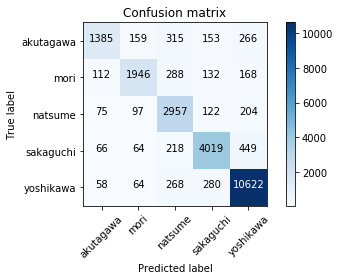

In [421]:
with mlflow.start_run():
    set_deterministic(deterministic)
    
    ## Log our parameters into mlflow
    num_train = int(num_train)
    args = Params(qrnn,bs,bptt,emb_sz, nh, nl,fine_tune_lm,lm_lr,lm_drop_mult,
                 use_pretrained_lm,clas_lr,clas_drop_mult,use_lm,num_train,deterministic)
    for key, value in vars(args).items():
        mlflow.log_param(key, value)
    
    ## create data set
    data_lm = TextLMDataBunch.load(path=Path(data_dir/dataset),cache_name=Path(f'tmp/lm/{num_train}'))
    data_clas = TextClasDataBunch.load(path=Path(data_dir/dataset),cache_name=Path(f'tmp/clas/{num_train}'))
    
    ## preprocess
    if qrnn:
        print('Using QRNNs...')
    model_name = 'qrnn' if qrnn else 'lstm'
    lm_name = f'{model_name}_{pretrain_name}'
    pretrained_fnames = (lm_name, f'itos_{pretrain_name}')

    ensure_paths_exists(data_dir,
                        dataset_dir,
                        model_dir,
                        model_dir/f"{pretrained_fnames[0]}.pth",
                        model_dir/f"{pretrained_fnames[1]}.pkl")
    lm_enc_finetuned  = f"{lm_name}_{dataset}_enc"
    cm_name = fig_dir / f'{lm_name}_{dataset}_confusionmatrix.png'

    ## fine tune lm 
    if use_lm:
        lm=lm_fine_tuning( data_lm, lm_lr, bptt, emb_sz, nh, nl, qrnn,
                    pad_token,
                    pretrained_fnames, 
                    model_dir,
                    lm_enc_finetuned,
                    lm_drop_mult, use_pretrained_lm,fine_tune_lm,deterministic)


    ## create classifier
    y_true, y_pred = classify_multiclas(data_clas, clas_lr, bptt, 
                        pad_token,
                        model_dir,
                        qrnn, emb_sz, nh, nl,clas_drop_mult,
                        fine_tune_lm, use_lm,deterministic)

    ## Evaluation
    results = evaluation(y_true,y_pred)
    class_names = data_clas.valid_ds.y.classes
    save_confusion_matrix(y_true,y_pred,class_names,cm_name)
    
    ## Log metrics
    for key, value in results.items():
        mlflow.log_metric(key, value)
        
    ## Save artifacts
    # pretrained lm
    mlflow.log_artifact(model_dir/f"{pretrained_fnames[0]}.pth")
    mlflow.log_artifact(model_dir/f"{pretrained_fnames[1]}.pkl")
    
    # fine tuned lm
    if fine_tune_lm & use_lm:
         mlflow.log_artifact(model_dir / f'{lm_enc_finetuned}.pth')
    
    # classifier
    mlflow.log_artifact(model_dir / f'{model_name}_{name}.pth')
    
    # confusion matrix
    mlflow.log_artifact(cm_name)
    